# Model Performance Visualization
## AUROC, PR Curves and Performance Comparison

In [32]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# --- Global style (tone & manner shared across notebooks) ---
sns.set_theme(
    style="whitegrid",
    context="talk",
    font_scale=0.95,
    rc={
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "grid.alpha": 0.35,
        "axes.grid": True,
    },
)
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True

In [33]:
# -----------------------------
# Configuration (edit here)
# -----------------------------
# Default: run everything on TEST. Change to 'dev' if you want dev plots.
SPLIT = 'test'  # 'test' (default) or 'dev'

# The 3 model variants for grid/barplot comparison
MODEL_KEYS = ['dn', 'dn+rr', 'dn+img']
MODEL_DISPLAY = {
    'dn': 'DN',
    'dn+rr': 'DN+RR',
    'dn+img': 'DN+CXR',
    'rr': 'RR',
    'img': 'CXR',
}

# Where those model keys live on disk.
# NOTE: dn+rr/dn+img are stored in rr/img folders currently
MODEL_FOLDER_MAP = {
    'dn': 'dn',
    'dn+rr': 'dn+rr',
    'dn+img': 'dn+img',
    'rr': 'rr',
    'img': 'img',
}

# Define palette to match your example tone
COLOR_PALETTE = {
    'dn': '#2E86AB',      # DN (Blue)
    'dn+rr': '#6A994E',   # DN+RR (Green)
    'dn+img': '#C73E1D',  # DN+CXR (Red)
    'rr': '#C73E1D',      # RR (red)
    'img': '#6A994E',     # CXR (green)
}

# Base path
BASE_PATH = Path('/chanhwi/CXR_info_disparity/trained_models')

# Conditions for the grouped bar plots / grid columns
CONDITION_SPECS = [
    ('plain_remove_cxr', '-Radiology-related Information'),
    ('plain', 'Baseline'),
    ('plain_add_pi', '+Patient Demographics'),
]

In [34]:
def _resolve_model_folder(model_key: str) -> Path:
    folder = MODEL_FOLDER_MAP.get(model_key, model_key)
    return BASE_PATH / folder


def load_predictions(model_key: str, split: str = SPLIT, variant: str = 'plain'):
    """Load predictions for a given model key.

    This supports multiple variants by filename:
      - plain_{split}_predictions.txt
      - plain_remove_cxr_{split}_predictions.txt
      - plain_add_pi_{split}_predictions.txt

    Args:
        model_key: one of MODEL_KEYS (dn, dn+rr, dn+img)
        split: 'dev' or 'test'
        variant: 'plain' | 'plain_remove_cxr' | 'plain_add_pi'

    Returns:
        y_true, y_scores (positive-class probability)
    """
    model_dir = _resolve_model_folder(model_key)
    pred_file = model_dir / f'{variant}_{split}_predictions.txt'

    if not pred_file.exists():
        print(f"Warning: {pred_file} does not exist")
        return None, None

    y_true = []
    y_scores = []

    with open(pred_file, 'r') as f:
        for line in f:
            data = json.loads(line.strip())
            y_true.append(int(data['label']))
            y_scores.append(float(data['probabilities'][1]))

    return np.array(y_true), np.array(y_scores)

In [35]:
def parse_score_file(model_key: str):
    """Parse score.txt and return metrics for all variants and splits.

    Expected header lines look like:
      - plain dev evaluation completed
      - plain test evaluation completed
      - plain_remove_cxr dev evaluation completed
      - plain_add_pi test evaluation completed

    Returns:
        results[variant][split] = {
            'auroc', 'auprc', 'auroc_ci', 'auprc_ci'
        }
    """
    score_file = _resolve_model_folder(model_key) / 'score.txt'

    if not score_file.exists():
        print(f"Warning: {score_file} does not exist")
        return {}

    results = {}
    current_variant = None
    current_split = None

    with open(score_file, 'r') as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue

            if line.endswith('evaluation completed'):
                # e.g. "plain_remove_cxr dev evaluation completed"
                parts = line.split()
                if len(parts) >= 2:
                    current_variant = parts[0]
                    current_split = parts[1]
                    results.setdefault(current_variant, {}).setdefault(current_split, {})
                continue

            if current_variant and current_split and ':' in line:
                k, v = line.split(':', 1)
                k = k.strip()
                v = v.strip()

                if k == 'AUROC':
                    results[current_variant][current_split]['auroc'] = float(v)
                elif k == 'AUPRC':
                    results[current_variant][current_split]['auprc'] = float(v)
                elif k == 'AUROC 95% CI':
                    ci = v.strip('()').split(',')
                    results[current_variant][current_split]['auroc_ci'] = (float(ci[0]), float(ci[1]))
                elif k == 'AUPRC 95% CI':
                    ci = v.strip('()').split(',')
                    results[current_variant][current_split]['auprc_ci'] = (float(ci[0]), float(ci[1]))

    return results


def get_metrics(model_key: str, split: str = SPLIT, variant: str = 'plain') -> dict:
    scores = parse_score_file(model_key)
    return scores.get(variant, {}).get(split, {})

## 1. ROC and PR Curves

In [36]:
def plot_roc_pr_curves(models_to_compare, split: str = SPLIT, variant: str = 'plain', figsize=(16, 6)):
    """Plot AUROC (ROC) and PR curves side-by-side (ROC left, PR right)."""
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    ax_roc = axes[0]
    ax_pr = axes[1]

    y_true_for_baseline = None

    for model_key in models_to_compare:
        y_true, y_scores = load_predictions(model_key, split=split, variant=variant)
        if y_true is None:
            continue

        y_true_for_baseline = y_true
        color = COLOR_PALETTE.get(model_key, '#333333')
        label_name = MODEL_DISPLAY.get(model_key, model_key)

        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, color=color, lw=2.8, label=f'{label_name} ({roc_auc:.4f})')

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = average_precision_score(y_true, y_scores)
        ax_pr.plot(recall, precision, color=color, lw=2.8, label=f'{label_name} ({pr_auc:.4f})')

    ax_roc.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5)
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('FP Rate')
    ax_roc.set_ylabel('TP Rate')
    ax_roc.set_title(f'ROC Curves', fontweight='bold')
    ax_roc.legend(loc='lower right')

    if y_true_for_baseline is not None:
        pos_rate = float(np.sum(y_true_for_baseline)) / float(len(y_true_for_baseline))
        ax_pr.axhline(y=pos_rate, color='k', linestyle='--', lw=1.5, alpha=0.5, label=f'Random ({pos_rate:.3f})')

    ax_pr.set_xlim([0.0, 1.0])
    ax_pr.set_ylim([0.0, 1.05])
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_title(f'PR Curves', fontweight='bold')
    ax_pr.legend(loc='upper right')

    plt.tight_layout()
    return fig

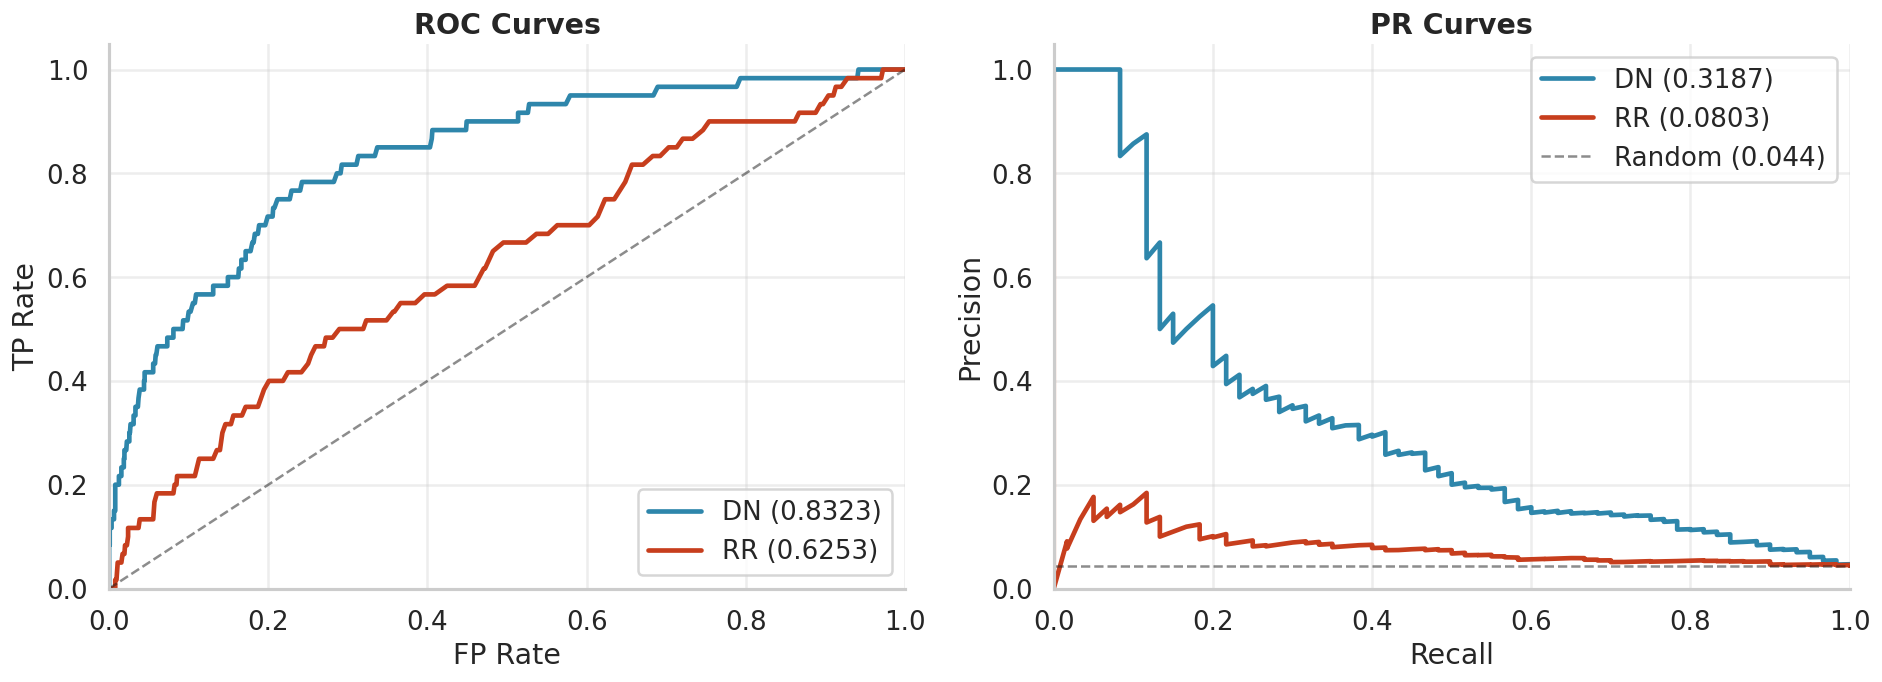

In [37]:
# -----------------------------
# 1) ROC + PR curves: dn vs rr vs img (DEFAULT: test)
# -----------------------------
# This compares the 3 raw folders (dn/rr/img) on 'plain' only.

models_to_compare_first = ['dn', 'rr', 'img']

fig = plot_roc_pr_curves(models_to_compare_first, split=SPLIT, variant='plain', figsize=(16, 6))
plt.show()

## 2. Grid Layout: Multiple Comparisons

In [38]:
def plot_comparison_grid(comparison_groups, split: str = SPLIT, figsize=(20, 12)):
    """Grid of ROC + PR curves.

    comparison_groups can be either:
      - {title: [model_keys]}  (variant assumed 'plain')
      - {title: {'variant': 'plain_add_pi', 'models': [model_keys]}}

    Each column = one group/condition, top row = ROC, bottom row = PR.
    """
    n_groups = len(comparison_groups)
    fig, axes = plt.subplots(2, n_groups, figsize=figsize)
    if n_groups == 1:
        axes = axes.reshape(-1, 1)

    for col_idx, (group_name, group) in enumerate(comparison_groups.items()):
        if isinstance(group, dict):
            variant = group.get('variant', 'plain')
            models = group.get('models', [])
        else:
            variant = 'plain'
            models = group

        ax_roc = axes[0, col_idx]
        ax_pr = axes[1, col_idx]

        y_true_for_baseline = None

        for model_key in models:
            y_true, y_scores = load_predictions(model_key, split=split, variant=variant)
            if y_true is None:
                continue

            y_true_for_baseline = y_true
            color = COLOR_PALETTE.get(model_key, '#333333')
            label_name = MODEL_DISPLAY.get(model_key, model_key)

            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            ax_roc.plot(fpr, tpr, color=color, lw=2.5, label=f'{label_name} ({roc_auc:.4f})')

            precision, recall, _ = precision_recall_curve(y_true, y_scores)
            pr_auc = average_precision_score(y_true, y_scores)
            ax_pr.plot(recall, precision, color=color, lw=2.5, label=f'{label_name} ({pr_auc:.4f})')

        ax_roc.plot([0, 1], [0, 1], 'k--', lw=1.2, alpha=0.5)
        ax_roc.set_xlim([0.0, 1.0])
        ax_roc.set_ylim([0.0, 1.05])
        # Plain summarization을 bold로 처리
        title_weight = 'bold'
        ax_roc.set_title(f'{group_name}\nROC curve', fontweight=title_weight)        
        ax_roc.tick_params(axis='y', labelsize=10)           
        ax_roc.tick_params(axis='x', labelsize=10)
        ax_roc.grid(True, alpha=0.3)
        ax_roc.legend(loc='lower right', frameon=True, fontsize=9)

        if col_idx == 0:
            ax_roc.set_ylabel('TP Rate', fontsize=12)
        ax_roc.set_xlabel('FP Rate', fontsize=12)

        if y_true_for_baseline is not None:
            pos_rate = float(np.sum(y_true_for_baseline)) / float(len(y_true_for_baseline))
            ax_pr.axhline(y=pos_rate, color='k', linestyle='--', lw=1.2, alpha=0.5)

        ax_pr.set_xlim([0.0, 1.0])
        ax_pr.set_ylim([0.0, 1.05])
        ax_pr.set_title('PR curve', fontweight=title_weight)
        ax_pr.tick_params(axis='y', labelsize=10)           
        ax_pr.tick_params(axis='x', labelsize=10)
        ax_pr.grid(True, alpha=0.3)
        ax_pr.legend(loc='upper right', frameon=True, fontsize=9)

        if col_idx == 0:
            ax_pr.set_ylabel('Precision', fontsize=12)
        ax_pr.set_xlabel('Recall', fontsize=12)

    # plt.suptitle(f'ROC Comparison', fontsize=16, y=1.02)
    plt.tight_layout()
    return fig

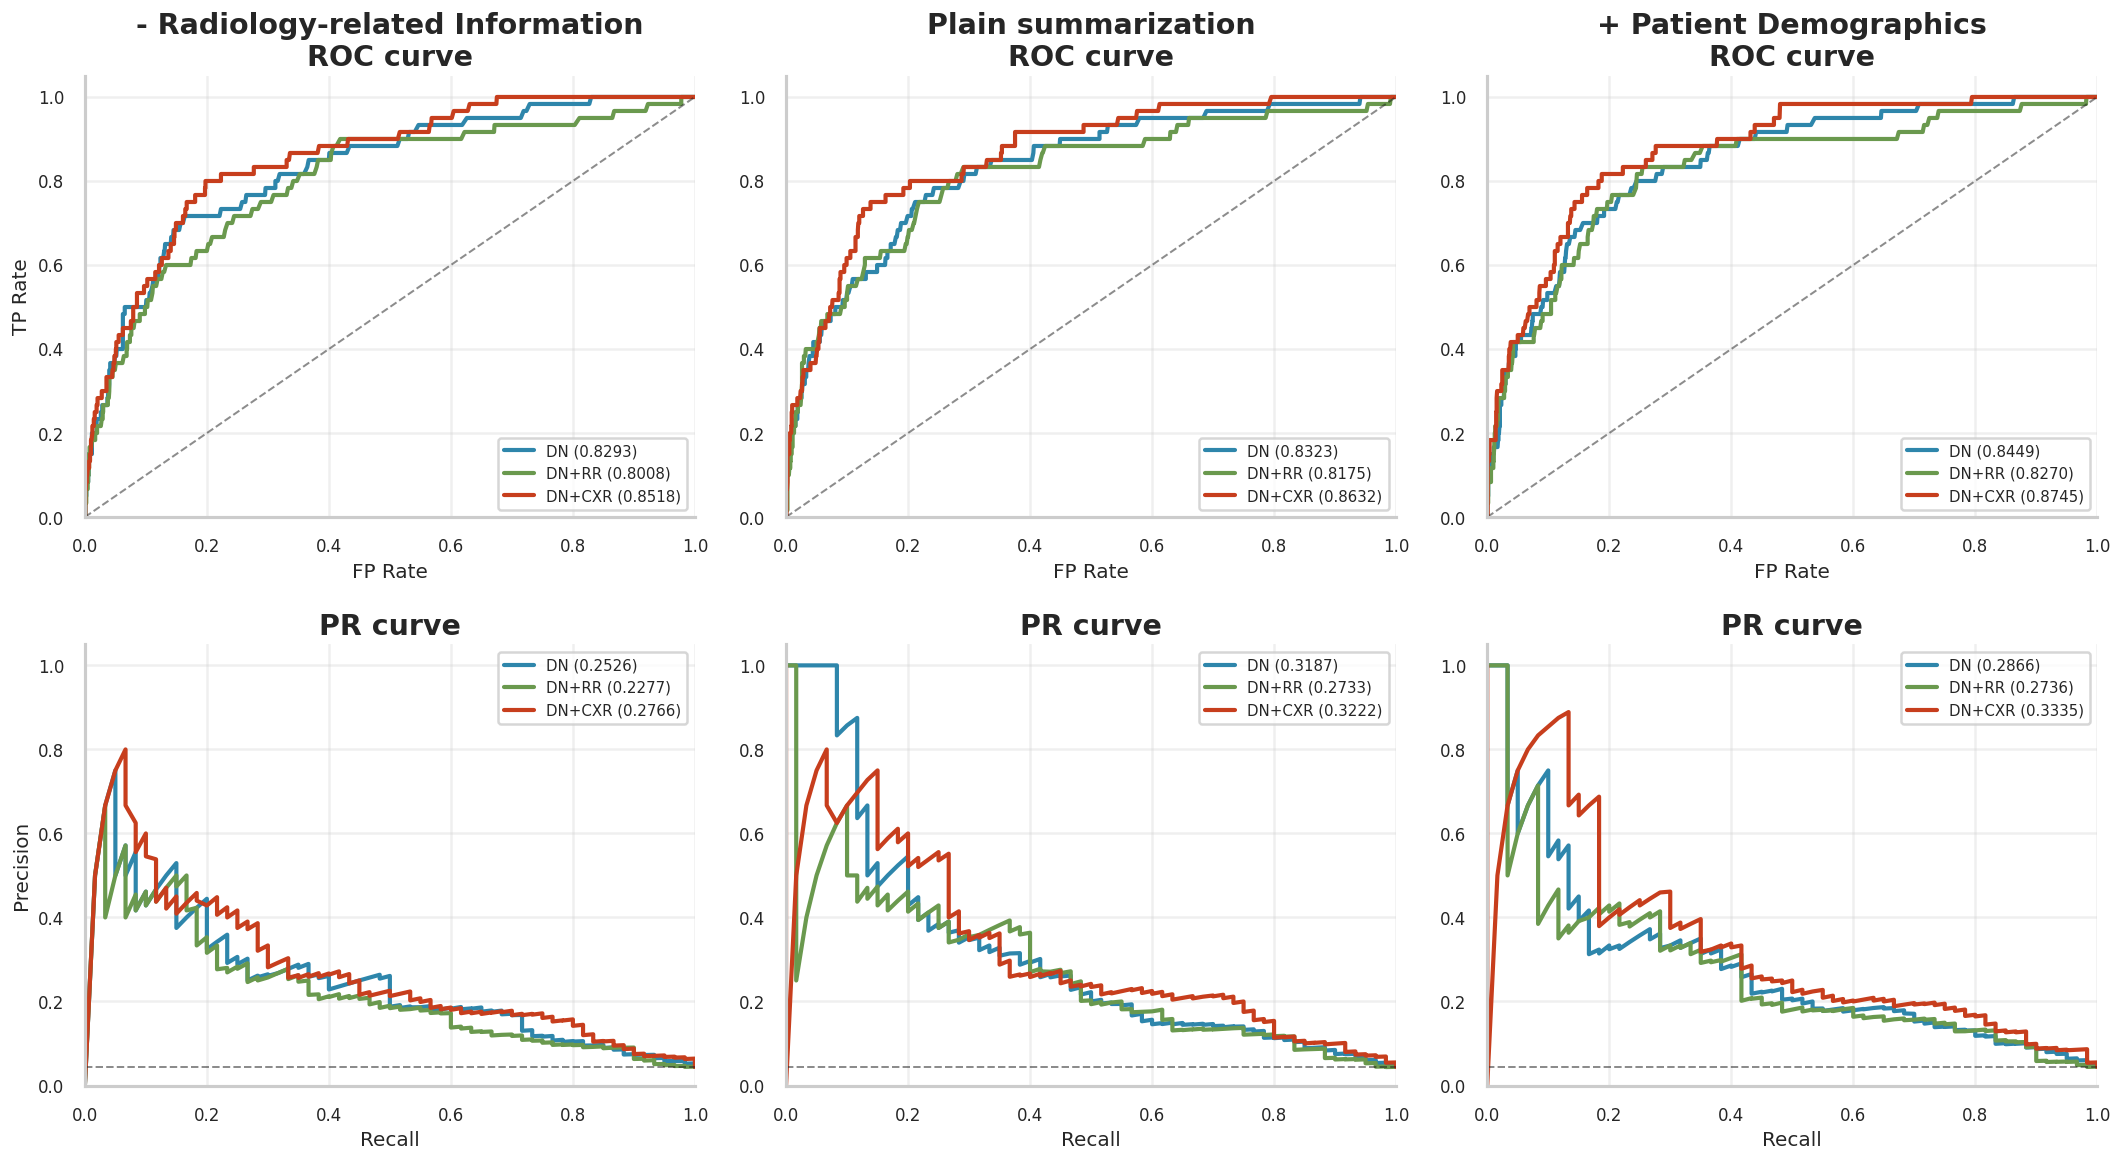

In [39]:
# -----------------------------
# 2) Grid comparison across 3 conditions
# -----------------------------
# Each column uses a different prediction file variant.
# (If rr/img don't have those variant files yet, you'll see warnings for the missing ones.)

comparison_groups = {
    '- Radiology-related Information': {'variant': 'plain_remove_cxr', 'models': MODEL_KEYS},
    'Plain summarization': {'variant': 'plain', 'models': MODEL_KEYS},
    '+ Patient Demographics': {'variant': 'plain_add_pi', 'models': MODEL_KEYS},
}

fig_grid = plot_comparison_grid(comparison_groups, split=SPLIT, figsize=(18, 10))
plt.show()

## 3. AUROC / AUPRC grouped bar plots (match the example)

- x-axis: **-Radiology-related Information / Baseline / +Patient Demographics**
- hue: **DN / DN+RR / DN+CXR**
- default split: **test** (`SPLIT='test'`), change to `'dev'` to regenerate.

In [9]:
def collect_condition_metrics(model_keys, split: str = SPLIT):
    """Collect AUROC/AUPRC (+CI) for the 3 conditions and 3 model variants."""
    rows = []

    for model_key in model_keys:
        for variant_key, condition_label in CONDITION_SPECS:
            m = get_metrics(model_key, split=split, variant=variant_key)

            rows.append({
                'Condition': condition_label,
                'ConditionKey': variant_key,
                'ModelKey': model_key,
                'Model': MODEL_DISPLAY.get(model_key, model_key),
                'AUROC': m.get('auroc', np.nan),
                'AUPRC': m.get('auprc', np.nan),
                'AUROC_CI': m.get('auroc_ci', (np.nan, np.nan)),
                'AUPRC_CI': m.get('auprc_ci', (np.nan, np.nan)),
            })

    df = pd.DataFrame(rows)
    # unwrap CI tuples into separate cols
    df[['AUROC_CI_L', 'AUROC_CI_U']] = pd.DataFrame(df['AUROC_CI'].tolist(), index=df.index)
    df[['AUPRC_CI_L', 'AUPRC_CI_U']] = pd.DataFrame(df['AUPRC_CI'].tolist(), index=df.index)
    return df

In [20]:
def plot_grouped_bar(df: pd.DataFrame, metric: str = 'AUROC', figsize=(12, 6), ylim=None):
    """Grouped bar plot matching the provided example.

    Important: rr/img currently don't have `plain_remove_cxr` / `plain_add_pi` sections in score/preds.
    This function keeps the grouped layout and prints 'NA' for missing combinations.

    CI display:
      - If `{metric}_CI_L` / `{metric}_CI_U` columns exist, draw 95% CI as asymmetric error bars.
      - Missing CI (or missing metric) is handled gracefully (no error bar).
    """
    assert metric in ('AUROC', 'AUPRC')

    condition_order = [label for _, label in CONDITION_SPECS]
    model_key_order = MODEL_KEYS
    model_label_order = [MODEL_DISPLAY[k] for k in model_key_order]

    # Build matrix [n_conditions x n_models]
    values = np.full((len(condition_order), len(model_key_order)), np.nan, dtype=float)

    ci_col_map = {
        'AUROC': ('AUROC_CI_L', 'AUROC_CI_U'),
        'AUPRC': ('AUPRC_CI_L', 'AUPRC_CI_U'),
    }
    ci_l = np.full_like(values, np.nan)
    ci_u = np.full_like(values, np.nan)
    lcol, ucol = ci_col_map[metric]
    has_ci_cols = (lcol in df.columns) and (ucol in df.columns)

    for ci, cond in enumerate(condition_order):
        for mi, mk in enumerate(model_key_order):
            sub = df[(df['Condition'] == cond) & (df['ModelKey'] == mk)]
            if len(sub) > 0:
                try:
                    values[ci, mi] = float(sub.iloc[0][metric])
                except Exception:
                    values[ci, mi] = np.nan

                if has_ci_cols:
                    try:
                        ci_l[ci, mi] = float(sub.iloc[0][lcol])
                        ci_u[ci, mi] = float(sub.iloc[0][ucol])
                    except Exception:
                        ci_l[ci, mi] = np.nan
                        ci_u[ci, mi] = np.nan

    if np.all(np.isnan(values)):
        print(f'No data to plot for {metric} ({SPLIT}).')
        return None

    fig, ax = plt.subplots(figsize=figsize)

    x = np.arange(len(condition_order))
    n_models = len(model_key_order)
    width = 0.24 if n_models == 3 else 0.18
    offsets = (np.arange(n_models) - (n_models - 1) / 2.0) * width

    palette = {MODEL_DISPLAY[k]: COLOR_PALETTE[k] for k in model_key_order}

    # y-limits first so NA annotations are placed correctly
    if ylim is not None:
        ax.set_ylim(*ylim)
    else:
        ax.set_ylim(0, 1.0)

    y0 = ax.get_ylim()[0]

    for mi, mk in enumerate(model_key_order):
        label = MODEL_DISPLAY[mk]
        y = values[:, mi]
        y_plot = np.nan_to_num(y, nan=0.0)

        yerr = None
        if has_ci_cols:
            # asymmetric CI error: [[lower_err], [upper_err]]
            lo = y - ci_l[:, mi]
            up = ci_u[:, mi] - y
            ok = np.isfinite(y) & np.isfinite(ci_l[:, mi]) & np.isfinite(ci_u[:, mi])
            lo = np.where(ok, lo, 0.0)
            up = np.where(ok, up, 0.0)
            yerr = np.vstack([lo, up])

        ax.bar(
            x + offsets[mi],
            y_plot,
            width=width,
            label=label,
            color=palette[label],
            edgecolor='black',
            linewidth=1.1,
            alpha=0.95,
            yerr=yerr,
            capsize=4,
            ecolor='black',
            error_kw={'elinewidth': 1.1, 'capthick': 1.1},
        )

        for xi, yi in zip(x + offsets[mi], y):
            if np.isnan(yi):
                ax.annotate('NA', (xi, y0), ha='center', va='bottom', fontsize=9, alpha=0.65, 
                           xytext=(0, 4), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', linewidth=0.5, alpha=0.9))
            else:
                ax.annotate(f'{yi:.4f}', (xi, yi), ha='center', va='bottom', fontsize=9, 
                           xytext=(0, 4), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='black', linewidth=0.6, alpha=1.0))

    ax.set_xticks(x)
    ax.set_xticklabels(condition_order)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(f'{metric}', fontweight='bold')

    ax.grid(True, axis='y', alpha=0.35)
    sns.despine(ax=ax)
    ax.legend(title=None, loc='upper left', frameon=True)

    plt.tight_layout()
    return fig

In [21]:
# Collect condition-wise metrics (AUROC/AUPRC) for the 3 models (dn/dn+rr/dn+img)
cond_df = collect_condition_metrics(MODEL_KEYS, split=SPLIT)

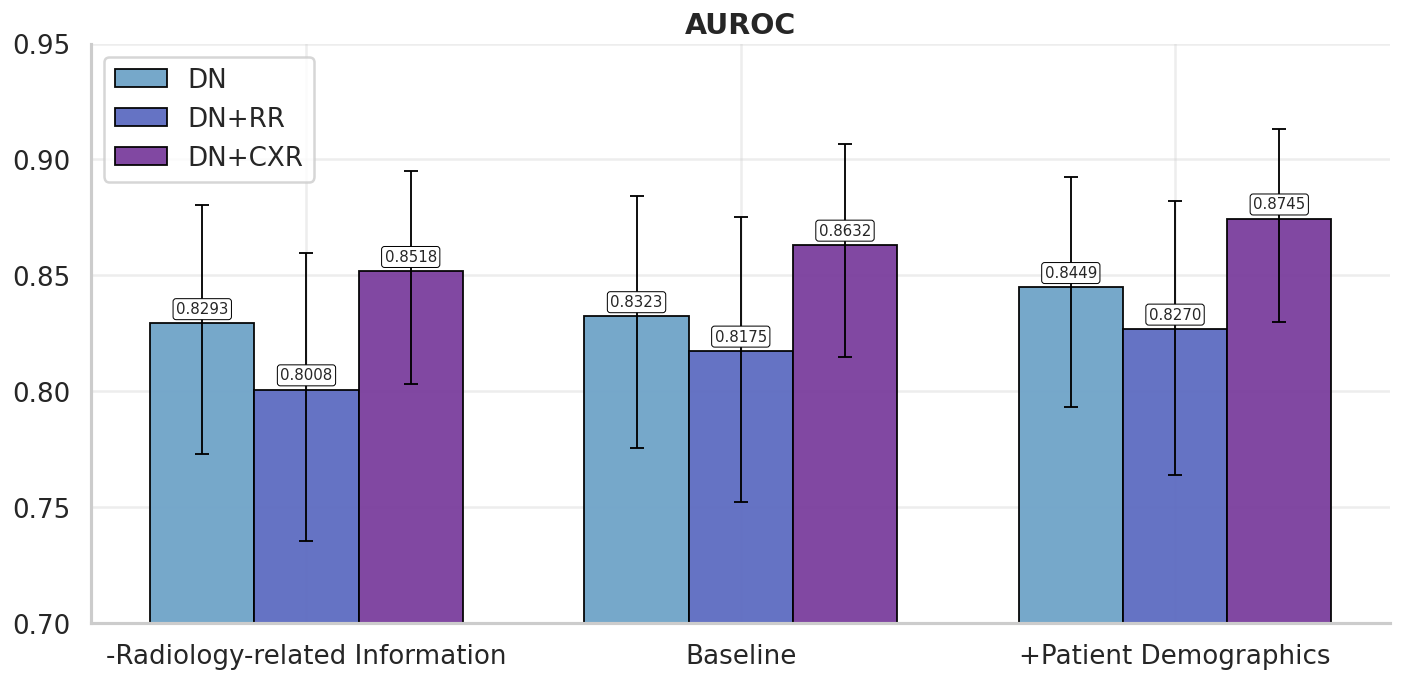

In [22]:
# AUROC grouped bar plot (example-style)
fig_auroc = plot_grouped_bar(
    cond_df,
    metric='AUROC',
    figsize=(12, 6),
    ylim=(0.70, 0.95),
)
if fig_auroc:
    plt.show()

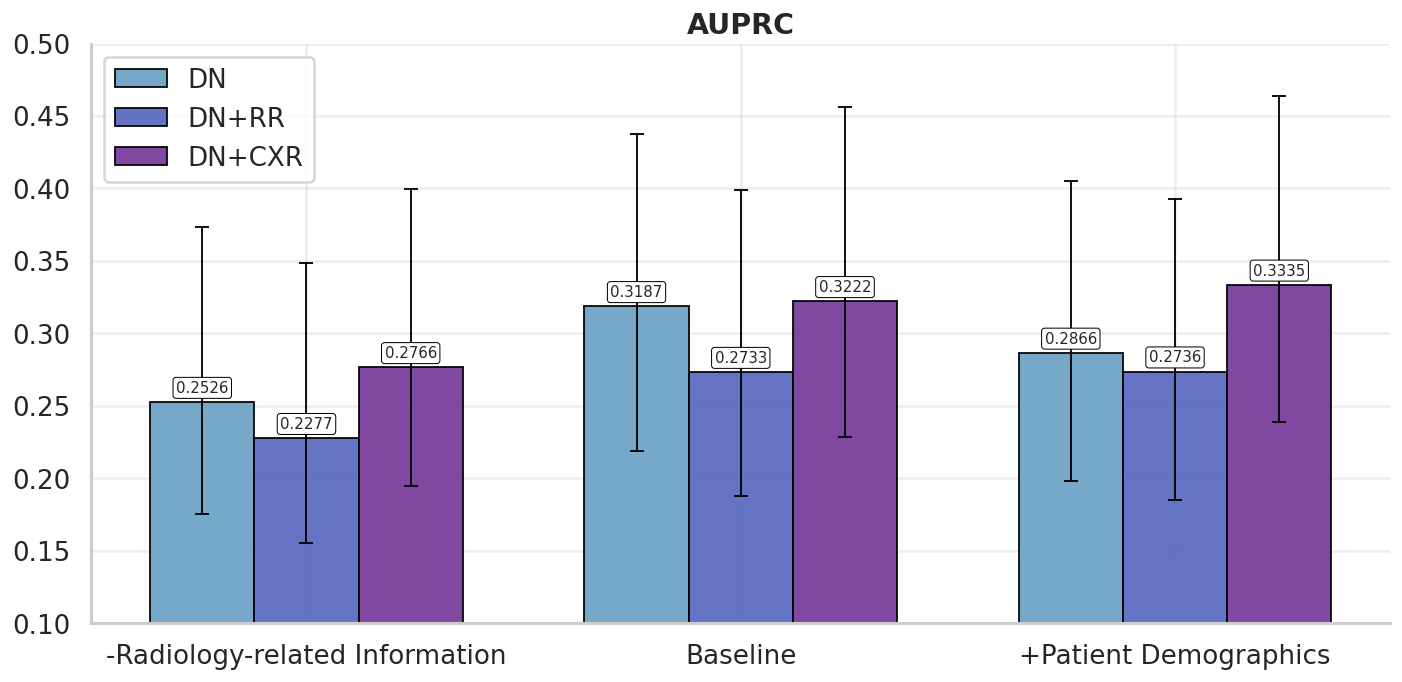

In [23]:
# AUPRC grouped bar plot (example-style)
fig_auprc = plot_grouped_bar(
    cond_df,
    metric='AUPRC',
    figsize=(12, 6),
    ylim=(0.1, 0.5),
)
if fig_auprc:
    plt.show()